In [3]:
%pylab inline
import pandas as pd
import os
import scipy.stats

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# Paths
DATADIR="/storage/mgymrek/chipmunk/fig1_eval"
OUTDIR=os.path.join(DATADIR, "pdfs")

FIG1COLOR = "darkblue"


Populating the interactive namespace from numpy and matplotlib


In [4]:
#factor = "GM12878_H3K27ac_ENCFF097SQI_ENCFF465WTH"
binsize=5
#factor = "GM12878_BACH1_ENCFF518TTP_ENCFF866OLZ"
#binsize=1
factor = "GM12878_CTCF_ENCFF584BRF_ENCFF559IXF"
binsize = 1

# Correlation plot chipmunk vs. encode

Overlap: (0.601348720384208, 0.0)
No overlap: (0.05629659435139948, 1.3389031710503642e-33)
All: (0.4447920757644204, 0.0)


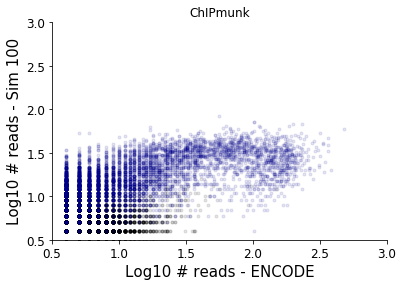

In [8]:
nc = 100
chipulate_nc = 1000000

# Assign bins as overlap/not peaks
peakbins = pd.read_csv(os.path.join(DATADIR, factor, "windows_%skb_peak.bed"%binsize), sep="\t", names=["chrom","pos","end"])
peakbins["overlap"] = True
nopeakbins = pd.read_csv(os.path.join(DATADIR, factor, "windows_%skb_nopeak.bed"%binsize), sep="\t", names=["chrom","pos","end"])
nopeakbins["overlap"] = False
binannot = pd.concat([peakbins, nopeakbins]).drop_duplicates()


# Load bin data - chipmunk
enc_bins = pd.read_csv(os.path.join(DATADIR, factor, factor+".ENCODE.cov.%skb.bed"%binsize), usecols=[1,2,3], names=["pos","end","enc.counts"], sep="\t")
sim_bins = pd.read_csv(os.path.join(DATADIR, factor, factor+".%s.cov.%skb.bed"%(nc, binsize)), usecols=[3], names=["sim.counts"], sep="\t")
bindata = pd.DataFrame({"pos": enc_bins["pos"], "end":enc_bins["end"], \
                        "enc.counts": enc_bins["enc.counts"], \
                        "sim.counts": sim_bins["sim.counts"]})
bindata = bindata[bindata["enc.counts"]+bindata["sim.counts"]>0]
bindata = pd.merge(bindata, binannot, on=["pos","end"])

# Load bin data - chipulate
#sim_bins2 = pd.read_csv(os.path.join(DATADIR, factor, factor+".%s.chipulate.cov.%skb.bed"%(chipulate_nc, binsize)), usecols=[3], names=["sim.counts"], sep="\t")
#bindata2 = pd.DataFrame({"pos": enc_bins["pos"], "end":enc_bins["end"], \
#                        "enc.counts": enc_bins["enc.counts"], \
#                        "sim.counts": sim_bins2["sim.counts"]})
#bindata2 = bindata2[bindata2["enc.counts"]+bindata2["sim.counts"]>0]
#bindata2 = pd.merge(bindata2, binannot, on=["pos","end"])


# Plot
alpha = 0.1
pc = 1 # pseudocount
fig = plt.figure()
fig.set_size_inches((6, 4))
ax = fig.add_subplot(111)
ax.scatter(np.log10(bindata[~bindata["overlap"]]["enc.counts"]+pc),
          np.log10(bindata[~bindata["overlap"]]["sim.counts"]+pc),
          color="black", alpha=alpha, marker=".")
ax.scatter(np.log10(bindata[bindata["overlap"]]["enc.counts"]+pc),
          np.log10(bindata[bindata["overlap"]]["sim.counts"]+pc),
          color="darkblue", alpha=alpha,  marker=".")
ax.set_xlim(left=0.5, right=3.0)
ax.set_ylim(bottom=0.5, top=3.0)
ax.set_xlabel("Log10 # reads - ENCODE", size=15)
ax.set_ylabel("Log10 # reads - Sim %s"%nc, size=15)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xticklabels(["%0.1f"%item for item in ax.get_xticks()], size=12)
ax.set_yticklabels(["%0.1f"%item for item in ax.get_yticks()], size=12);
ax.set_title("ChIPmunk")
fig.savefig(os.path.join(OUTDIR, "SuppFig_BinsExample_vsNC_scatter_%s_chipmunk.pdf"%factor))


"""
fig = plt.figure()
fig.set_size_inches((6, 4))
ax = fig.add_subplot(111)
ax.scatter(np.log10(bindata2[~bindata2["overlap"]]["enc.counts"]+pc),
          np.log10(bindata2[~bindata2["overlap"]]["sim.counts"]+pc),
          color="black", alpha=alpha, marker=".")
ax.scatter(np.log10(bindata2[bindata2["overlap"]]["enc.counts"]+pc),
          np.log10(bindata2[bindata2["overlap"]]["sim.counts"]+pc),
          color="darkblue", alpha=alpha,  marker=".")
#ax.set_xlim(left=0.5, right=3.0)
#ax.set_ylim(bottom=0.5, top=3.0)
ax.set_xlabel("Log10 # reads - ENCODE", size=15)
ax.set_ylabel("Log10 # reads - Sim %s"%nc, size=15)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xticklabels(["%0.1f"%item for item in ax.get_xticks()], size=12)
ax.set_yticklabels(["%0.1f"%item for item in ax.get_yticks()], size=12);
ax.set_title("Chipulate")
fig.savefig(os.path.join(OUTDIR, "SuppFig_BinsExample_vsNC_scatter_%s_chipulate.pdf"%factor))
"""


# Print corr
for b in [bindata]: #, bindata2]:
    peakbins_corr = (scipy.stats.pearsonr(np.log10(b[b["overlap"]]["enc.counts"]+pc), np.log10(b[b["overlap"]]["sim.counts"]+pc)))
    nopeakbins_corr = (scipy.stats.pearsonr(np.log10(b[~b["overlap"]]["enc.counts"]+pc), np.log10(b[~b["overlap"]]["sim.counts"]+pc)))
    all_corr = (scipy.stats.pearsonr(np.log10(b["enc.counts"]+pc), np.log10(b["sim.counts"]+pc)))

    print("Overlap: %s"%str(peakbins_corr))
    print("No overlap: %s"%str(nopeakbins_corr))
    print("All: %s"%str(all_corr))

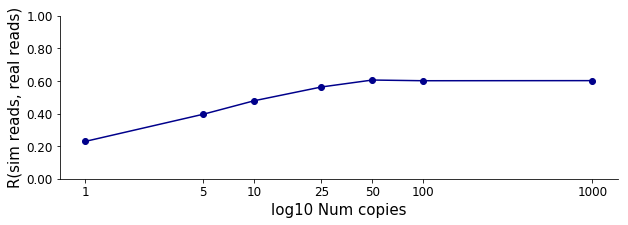

In [9]:
#### get corr for different cell nums
enc_bins = pd.read_csv(os.path.join(DATADIR, factor, factor+".ENCODE.cov.%skb.bed"%binsize), usecols=[1,2,3], names=["pos","end","enc.counts"], sep="\t")

ncs = [1, 5, 10, 25, 50, 100, 1000]
chipulate_ncs = [1, 2, 5, 10, 100, 1000, 1000000]
rvals_peak = []
rvals_peak_chipulate = []
for nc in ncs:
    sim_bins = pd.read_csv(os.path.join(DATADIR, factor, factor+".%s.cov.%skb.bed"%(nc, binsize)), usecols=[3], names=["sim.counts"], sep="\t")
    bindata = pd.DataFrame({"pos": enc_bins["pos"], "end": enc_bins["end"], 
                            "enc.counts": enc_bins["enc.counts"], "sim.counts": sim_bins["sim.counts"]})
    bindata = bindata[bindata["enc.counts"]+bindata["sim.counts"]>0]
    bindata = pd.merge(bindata, binannot, on=["pos","end"])

    # separate by overlap/no overlap peaks  
    r_peak = scipy.stats.pearsonr(np.log10((bindata[bindata["overlap"]]["enc.counts"])+pc), np.log10(bindata[bindata["overlap"]]["sim.counts"]+pc))[0]
    rvals_peak.append(r_peak)

"""
for nc in chipulate_ncs:
    sim_bins = pd.read_csv(os.path.join(DATADIR, factor, factor+".%s.chipulate.cov.%skb.bed"%(nc, binsize)), usecols=[3], names=["sim.counts"], sep="\t")
    bindata = pd.DataFrame({"pos": enc_bins["pos"], "end": enc_bins["end"], 
                            "enc.counts": enc_bins["enc.counts"], "sim.counts": sim_bins["sim.counts"]})
    bindata = bindata[bindata["enc.counts"]+bindata["sim.counts"]>0]
    bindata = pd.merge(bindata, binannot, on=["pos","end"])

    # separate by overlap/no overlap peaks  
    r_peak = scipy.stats.pearsonr(np.log10((bindata[bindata["overlap"]]["enc.counts"])+pc), np.log10(bindata[bindata["overlap"]]["sim.counts"]+pc))[0]
    rvals_peak_chipulate.append(r_peak)
    
fig = plt.figure()
fig.set_size_inches((10, 3))
ax = fig.add_subplot(111)
ax.plot(np.log10(chipulate_ncs), rvals_peak_chipulate, marker="o", color="darkred");
ax.set_xlabel("log10 Num copies", size=15)
ax.set_ylabel("R(sim reads, real reads)", size=15)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_ylim(bottom=0.0, top=1.0)
ax.set_xticks(np.log10(chipulate_ncs))
ax.set_xticklabels(chipulate_ncs, size=12)
ax.set_yticklabels(["%0.2f"%item for item in ax.get_yticks()], size=12);
fig.savefig(os.path.join(OUTDIR, "SuppFig_BinsExample_vsNC_%s_chipulate.pdf"%factor))

"""

    
fig = plt.figure()
fig.set_size_inches((10, 3))
ax = fig.add_subplot(111)
ax.plot(np.log10(ncs), rvals_peak, marker="o", color="darkblue");
ax.set_xlabel("log10 Num copies", size=15)
ax.set_ylabel("R(sim reads, real reads)", size=15)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_ylim(bottom=0.0, top=1.0)
ax.set_xticks(np.log10(ncs))
ax.set_xticklabels(ncs, size=12)
ax.set_yticklabels(["%0.2f"%item for item in ax.get_yticks()], size=12);
fig.savefig(os.path.join(OUTDIR, "SuppFig_BinsExample_vsNC_%s.pdf"%factor))



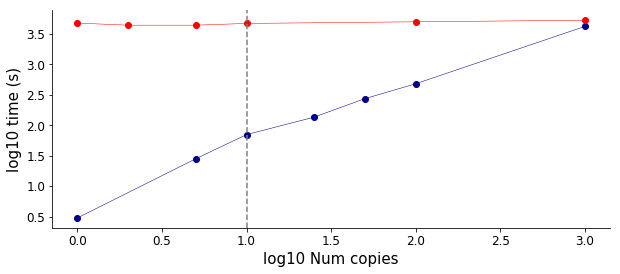

In [11]:
# Time vs. num copies
ncs = [1, 5, 10, 25, 50, 100, 1000] 
timing = [3, 28, 60+10, 2*60+15, 4*60+32, 7*60+58, 69*60+28]
chipulate_ncs = [1, 2, 5, 10, 100, 1000]
chipulate_timing = [item*60 for item in [79,73,73,78,83,88] ]
fig = plt.figure()
fig.set_size_inches((10, 4))
ax = fig.add_subplot(111)
ax.plot(np.log10(ncs), np.log10(timing), marker="o", linewidth=0.5, color="darkblue")
ax.plot(np.log10(chipulate_ncs), np.log10(chipulate_timing), marker="o", linewidth=0.5, color="red")
ax.axvline(x=np.log10(10), linestyle="dashed", color="gray")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel("log10 Num copies", size=15)
ax.set_ylabel("log10 time (s)", size=15)
ax.set_xticklabels(["%0.1f"%item for item in ax.get_xticks()], size=12)
ax.set_yticklabels(["%0.1f"%item for item in ax.get_yticks()], size=12);
#fig.savefig(os.path.join(OUTDIR, "SuppFig_BinsExample_vsNC_timing_%s.pdf"%factor))

In [35]:
# Look at model as a function of cell number
ncs = [1, 5, 10, 25, 50, 100, 1000]
import json
actual = json.load(open(os.path.join("/storage/mgymrek/chipmunk/encode", factor, "%s.json"%(factor))))
print("NumCells\tLearnedFromReal-s\tLearnFromSim-s\tLeanredFromReal-ratio\tLearndFromSim-ratio")

def Ratio(model):
    f = model["pulldown"]["f"]
    s = model["pulldown"]["s"]
    return 1/(f/(1-f)*(1-s)/s)

for nc in ncs:
    model = json.load(open(os.path.join(DATADIR, factor, "%s.%s.json.json"%(factor, nc)), "r"))
    act_ratio = Ratio(actual)
    learn_ratio = Ratio(model)
    print("%s\t%s\t%s\t%s\t%s"%(nc, actual["pulldown"]["s"], model["pulldown"]["s"], act_ratio,learn_ratio))

NumCells	LearnedFromReal-s	LearnFromSim-s	LeanredFromReal-ratio	LearndFromSim-ratio
1	0.24198181927204132	0.43790456652641296	26.51831948690605	27.99909985918685
5	0.24198181927204132	0.444690078496933	26.51831948690605	28.780388991690717
10	0.24198181927204132	0.45158445835113525	26.51831948690605	29.59401472014291
25	0.24198181927204132	0.4557752311229706	26.51831948690605	30.098653601037853
50	0.24198181927204132	0.4558100402355194	26.51831948690605	30.10287774562527
100	0.24198181927204132	0.4268125891685486	26.51831948690605	26.761794407360664
1000	0.24198181927204132	0.4266374111175537	26.51831948690605	26.742637369969227
10000	0.24198181927204132	0.4289701282978058	26.51831948690605	26.998701390553222
